Let's first import the packages

In [1]:
import vip_hci as vip
from hci_postproc_with_likelihood import HCIAndromeda, HCIPca, HCILLSG, HCIAnnPca
from roc_updated_vip_roc import EvalRoc #Our suggestion for TPs 
from sklearn import metrics
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import pickle
from vip_hci.var import frame_center
from util import pixels_in_annulus
from vip_hci.conf import VLT_NACO, VLT_SPHERE_IRDIS
from packaging import version
from vip_hci.fits import open_fits
from vip_hci.var import fit_2dgaussian
from vip_hci.preproc import frame_crop
from hciplot import plot_frames
from vip_hci.var import get_annulus_segments

In [2]:
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.metrics import normalize_psf
    from vip_hci.pca import pca_annular
    from vip_hci.negfc import firstguess, cube_planet_free
else:
    from vip_hci.fm import normalize_psf, firstguess, cube_planet_free
    from vip_hci.psfsub import pca_annular

VIP version:  1.2.0


Let's load the data and then normalize PSF according to VIP tutorial.

In [3]:
cubename = '../datasets/naco_betapic_cube_cen'
angname = '../datasets/naco_betapic_pa'
psfnaco = '../datasets/naco_betapic_psf'

cube = open_fits(cubename)
pa = open_fits(angname)
psf = open_fits(psfnaco)

Fits HDU-0 data successfully loaded. Data shape: (61, 101, 101)
Fits HDU-0 data successfully loaded. Data shape: (61,)
Fits HDU-0 data successfully loaded. Data shape: (39, 39)


In [4]:
# this part is received from vip_extras of VIP-HCI package
derot_off = 104.84 # NACO derotator offset for this observation (Absil et al. 2013)
TN = -0.45         # Position angle of true north for NACO at the epoch of observation (Absil et al. 2013)
angs = pa-derot_off-TN

/home/hazan/.local/lib/python3.8/site-packages/hciplot/hciplot.py:401: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = subplot(rows, cols, v)


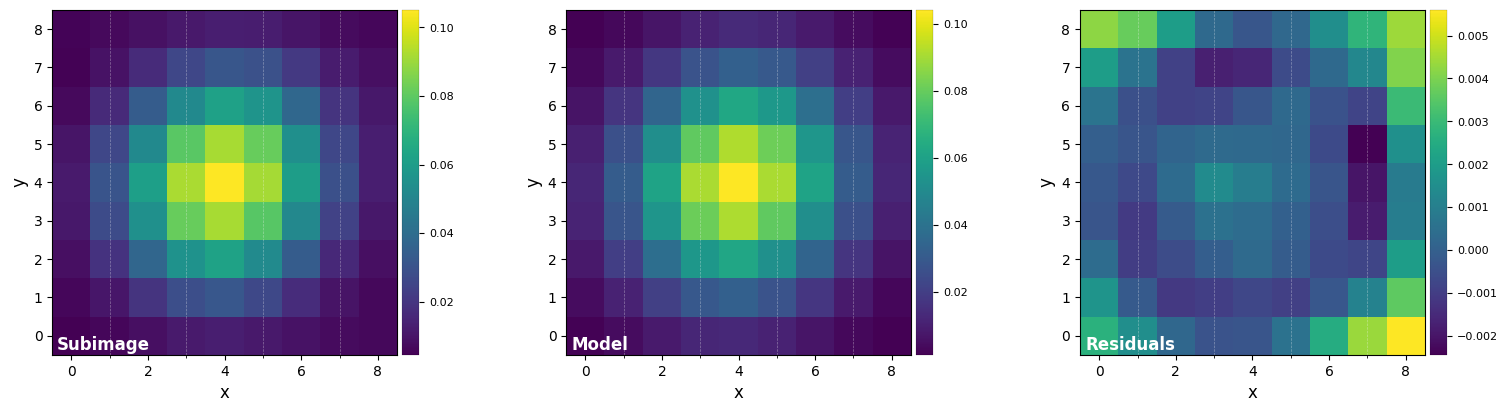

FWHM_y = 4.733218722257407
FWHM_x = 4.473682405059958 

centroid y = 19.006680059041216
centroid x = 18.999424475165455
centroid y subim = 4.006680059041214
centroid x subim = 3.9994244751654535 

amplitude = 0.10413004853269707
theta = -34.08563676836685


In [5]:
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)

In [6]:
fwhm_naco = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])
print(fwhm_naco)

4.603450563658683


In [7]:
psfn = normalize_psf(psf, fwhm_naco, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 1.228


In [8]:
imlib_rot = 'opencv' #'skimage'
interpolation='lanczos4' #'biquintic'   
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


We need to remove the real planet from the dataset, so we use VIP functions to remove it.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:29:34
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [58,36], running ...
Step | flux    | chi2r
1/30   0.100   748.776
2/30   0.149   748.739
3/30   0.221   748.681
4/30   0.329   748.596
5/30   0.489   748.470
6/30   0.728   748.281
7/30   1.083   747.998
8/30   1.610   747.563
9/30   2.395   746.898
10/30   3.562   745.903
11/30   5.298   744.429
12/30   7.880   742.216
13/30   11.721   739.094
14/30   17.433   734.373
15/30   25.929   727.496
16/30   38.566   717.614
17/30   57.362   703.622
18/30   85.317   681.881
19/30   126.896   650.244
20/30   188.739   610.617
21/30   280.722   541.471
22/30   417.5

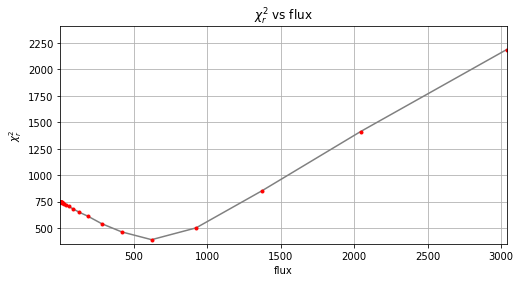

Planet 0: preliminary guess: (r, theta, f)=(16.1, 299.7, 621.0)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 100, nfev: 227, chi2r: 272.8569030761719
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(16.736, 300.640, 654.962) at 
          (X,Y)=(58.53, 35.60)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:22.226926
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [9]:
r_lo, theta_lo, f_lo = firstguess(cube, angs, psfn, plsc= pxscale_naco,ncomp=5, planets_xy_coord=[(58,36)], 
                                  fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                  aperture_radius=2, simplex=True, imlib=imlib_rot, 
                                  interpolation=interpolation, plot=True, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:29:57
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [58,36], running ...
Step | flux    | chi2r
1/30   0.100   432.593
2/30   0.149   432.564
3/30   0.221   432.521
4/30   0.329   432.460
5/30   0.489   432.368
6/30   0.728   432.231
7/30   1.083   432.021
8/30   1.610   431.721
9/30   2.395   431.271
10/30   3.562   430.613
11/30   5.298   429.662
12/30   7.880   428.406
13/30   11.721   426.577
14/30   17.433   423.736
15/30   25.929   419.115
16/30   38.566   412.269
17/30   57.362   401.088
18/30   85.317   386.320
19/30   126.896   363.897
20/30   188.739   334.990
21/30   280.722   295.810
22/30   417.5

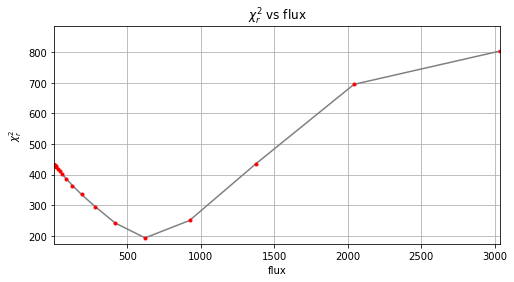

Planet 0: preliminary guess: (r, theta, f)=(16.1, 299.7, 621.0)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 141, nfev: 321, chi2r: 134.38931274414062
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(16.741, 300.804, 658.468) at 
          (X,Y)=(58.57, 35.62)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:36.243162
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [10]:
r_0, theta_0, f_0  = firstguess(cube, angs, psfn, plsc=pxscale_naco, ncomp=10, planets_xy_coord=[(58,36)], 
                                  fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                  aperture_radius=2, imlib=imlib_rot, interpolation=interpolation, 
                                  simplex=True, plot=True, verbose=True)

In [11]:
plpar_fc = [(r_0[0], theta_0[0], f_0[0])]

In [12]:
cube_emp = cube_planet_free(plpar_fc, cube, angs, psfn, plsc=pxscale_naco, imlib=imlib_rot, interpolation=interpolation)

Now, it is time to apply annular PCA to empty data cube.

In [13]:
from vip_hci.preproc import cube_derotate
from vip_hci.config import time_ini, timing
t0 = time_ini()
fr_pca_emp = pca_annular(cube_emp, angs, ncomp=10, asize=4*fwhm_naco, 
                         imlib=imlib_rot, interpolation=interpolation)
timing(t0)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:30:58
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:30:58
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 2, FWHM = 4.000
PCA per annulus (or annular sectors):
Ann 1    PA thresh:  2.49    Ann center:   9    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.194065
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  8.59    Ann center:  27    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.503640
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done derotating and combining.
Running time:  0:00:00.579832
――――――――――――――――――――――――――――――――――――――――――――――――――

And compare it with the original dataset result.

In [14]:
fr_pca = pca_annular(cube, angs, ncomp=10, asize=4*fwhm_naco, 
                         imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:31:04
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 2, FWHM = 4.000
PCA per annulus (or annular sectors):
Ann 1    PA thresh:  2.49    Ann center:   9    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.175502
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  8.59    Ann center:  27    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.485347
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done derotating and combining.
Running time:  0:00:00.560797
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [15]:
cropped_frame1 = frame_crop(fr_pca, cenxy=(58,36), size=15)

New shape: (15, 15)


In [16]:
cropped_frame2 = frame_crop(fr_pca_emp, cenxy=(58,36), size=15)

New shape: (15, 15)


/home/hazan/.local/lib/python3.8/site-packages/hciplot/hciplot.py:432: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = subplot(rows, cols, v, projection='3d')


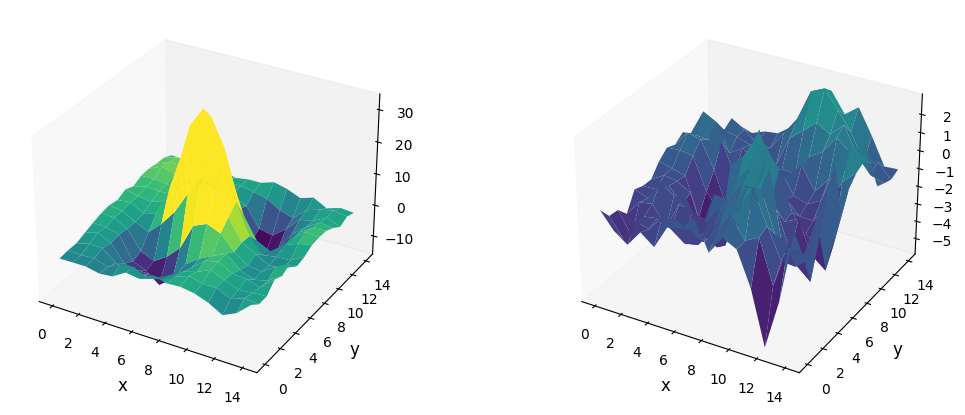

In [17]:
plot_frames((cropped_frame1, cropped_frame2), mode='surface', vmax=8)

/home/hazan/.local/lib/python3.8/site-packages/hciplot/hciplot.py:401: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = subplot(rows, cols, v)


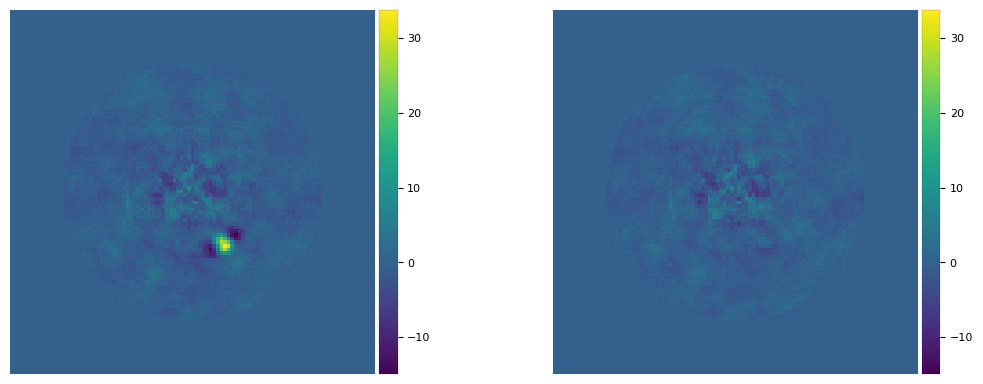

In [18]:
plot_frames((fr_pca, fr_pca_emp), vmin = float(np.amin(fr_pca)), 
            vmax= float(np.amax(fr_pca)), axis=False)

Since we are sure that the data cube is empty, we can use it to construct ROC curves.

Cube array shape: (61, 101, 101)
Angles array shape: (61,)
PSF array shape: (39, 39)
Normalized PSF array shape: (21, 21)
The attribute `psfn` contains the normalized PSF
`fwhm` attribute set to
4.801
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:31:24
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2d gauss-fitting
frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.651638
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


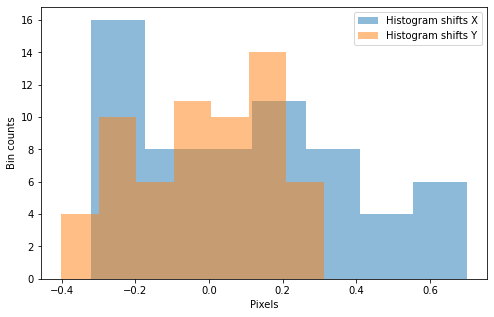

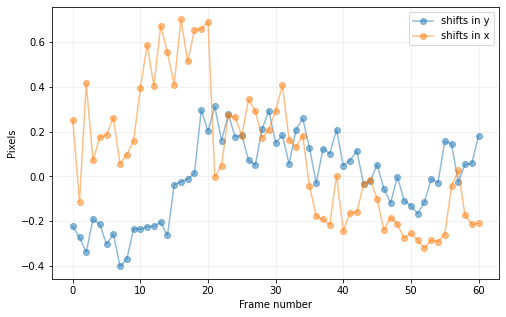

In [18]:
dataset = vip.hci_dataset.Dataset(
    cube=cube_emp,
    angles=angs,
    psf=psf
)

# Normalize PSF
dataset.normalize_psf(verbose=False, size=21)
dataset.recenter(negative=True, plot=False, verbose=False)

We prefer using the standard deviation of the annulus as flux value for the injected planets.

In [19]:
# Obtain the standard deviation of the first annulus
outer_r = 2
inner_r = 1.5
outer = (outer_r+0.5)*dataset.fwhm 
inner = (inner_r-0.5)*dataset.fwhm
width = outer - inner
yy, xx = get_annulus_segments(dataset.cube[0], inner, width)[0]
matrix_segm = dataset.cube[:, yy, xx]
flux = np.std(matrix_segm)

Then, for likelihood ratio map, we should define the pixels (Y,X) in the annulus. 

In [20]:
cy, cx = frame_center(cube)
pixels = pixels_in_annulus(cube.shape[1:], (cy, cx), dataset.fwhm*inner_r, dataset.fwhm*outer_r)

Let's call the class of ROC curve. We use a similar version of VIP package, but we modified it according to the our ROC curve suggestion and likelihood ratio map.

In [21]:
obj_roc = EvalRoc(dataset, n_injections=len(pixels), dist_flux=("uniform", flux*1, flux*1), 
                  inrad=dataset.fwhm*inner_r, outrad=dataset.fwhm*outer_r)

In [23]:
pcaalg20 = HCIAnnPca(dataset,ncomp=20, inner=inner, outer=outer, asize=dataset.fwhm)
obj_roc.add_algo('pca20',pcaalg20 , obj_roc.COLOR_1, obj_roc.SYMBOL_1, thresholds=np.array(np.arange(-2,8,0.02)))

adimsdi: double
asize: 4.800947709292663
check_mem: True
collapse: median
crop_ifs: True
dataset: <vip_hci.hci_dataset.Dataset object at 0x7f429b801670>
delta_rot: 1
delta_sep: (0.1, 1)
imlib: opencv
inner: 4.800947709292663
interpolation: lanczos4
mask_center_px: None
n_segments: 1
ncomp: 20
ncomp2: 1
outer: 12.002369273231658
radius_int: 0
scale_list: None
scaling: None
source_xy: None
svd_mode: lapack
verbose: True


We also need to give a location (dist and angle) for the injected planet. We prefer to have a deterministic result, so we inject the planet into the each pixel in the annulus. In each experiment, we inject only one planet. So we have the number of pixels in the annulus times experiments.

In [25]:
# Inject planet in each pixel of the annulus
obj_roc.dists = []
obj_roc.thetas = []
for p_pos in pixels:
    injx = p_pos[1]
    injy = p_pos[0]
    injx -= frame_center(dataset.cube[0])[1]
    injy -= frame_center(dataset.cube[0])[0]
    dist = np.sqrt(injx**2 + injy**2)
    theta = np.mod(np.arctan2(injy, injx) / np.pi * 180, 360)
    obj_roc.dists.append(dist)
    obj_roc.thetas.append(theta)

However, if you may want to see the results in a shorter time, you can give only 10 pixels as an input.

In [26]:
# To decrease computation time, lets try for 10 injections
obj_roc.n_injections = 10
pixels = pixels[:10]
obj_roc.dists = obj_roc.dists[:10]
obj_roc.thetas = obj_roc.thetas[:10]

Let's start to run the algorithm.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:33:58
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
0.9% of CEVR with 4 PCs
injecting


/home/hazan/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/hazan/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:33:58
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.059003
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.138332
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  6.87    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.242057
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.54    Ann center:  17    N segments: 1 
Done PCA with lapack for curr

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 372 out of 372 | elapsed:    7.7s finished


0% [###                           ] 100% | ETA: 00:02:02――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:34:11
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.070824
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.158518
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  6.87    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.296995
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.54    Ann cen

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 372 out of 372 | elapsed:    2.5s finished


0% [######                        ] 100% | ETA: 00:01:28――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:34:20
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.065167
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.158926
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  6.87    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.278423
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.54    Ann cen

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 372 out of 372 | elapsed:    2.4s finished


0% [#########                     ] 100% | ETA: 00:01:12――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:34:29
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.061666
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.154303
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  6.87    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.278179
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.54    Ann cen

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 372 out of 372 | elapsed:    2.5s finished


0% [############                  ] 100% | ETA: 00:00:59――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:34:37
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.062256
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.156996
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  6.87    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.274368
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.54    Ann cen

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 372 out of 372 | elapsed:    2.4s finished


0% [###############               ] 100% | ETA: 00:00:48――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:34:46
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.065074
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.167694
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  6.87    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.290392
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.54    Ann cen

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 357 out of 372 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 372 out of 372 | elapsed:    2.7s finished


0% [##################            ] 100% | ETA: 00:00:38――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:34:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.134979
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.307648
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  6.87    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.490134
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.54    Ann cen

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 357 out of 372 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 372 out of 372 | elapsed:    2.4s finished


0% [#####################         ] 100% | ETA: 00:00:28――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:35:05
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.062807
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.158085
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  6.87    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.278235
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.54    Ann cen

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 357 out of 372 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 372 out of 372 | elapsed:    2.4s finished


0% [########################      ] 100% | ETA: 00:00:18――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:35:13
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.064211
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.162733
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  6.87    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.293592
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.54    Ann cen

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 357 out of 372 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 372 out of 372 | elapsed:    2.8s finished


0% [###########################   ] 100% | ETA: 00:00:09――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:35:22
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.063067
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.160896
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  6.87    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.373398
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.54    Ann cen

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 372 out of 372 | elapsed:    2.8s finished


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:33
Running time:  0:01:33.840809
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


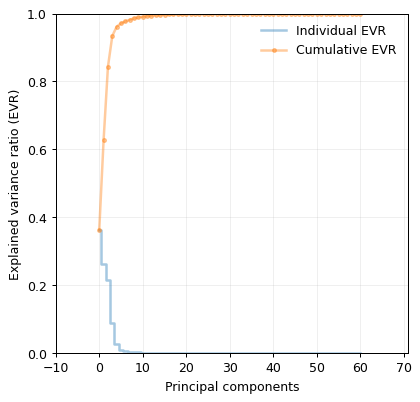

In [28]:
obj_roc.inject_and_postprocess(patch_size=7)

We compare likelihood ratio with flux-SNR and median-SNR

In [30]:
obj_roc2 = deepcopy(obj_roc)
obj_roc3 = deepcopy(obj_roc)

In [31]:
obj_roc.methods.append(obj_roc2.methods[0])
obj_roc.methods.append(obj_roc3.methods[0])

In [32]:
obj_roc.methods[1]['probmaps'] = deepcopy(obj_roc.methods[1]['probmaps_snr_fluxmap'])
obj_roc.methods[2]['probmaps'] = deepcopy(obj_roc.methods[2]['probmaps_likelihood'])

And likelihood ratio has different range than SNR, so we change it.

In [33]:
obj_roc.methods[2].thresholds = np.array(np.arange(0,500,1))

In [34]:
obj_roc.methods[0].name = "median-snr"
obj_roc.methods[1].name = "flux-snr"
obj_roc.methods[2].name = "likelihood"
obj_roc.methods[1].symbol = "-."
obj_roc.methods[2].symbol = ":"

Calculate TPR and FPR.

In [35]:
obj_roc.compute_tpr_fpr_allblobs(plot=False, overlap_threshold=0)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-11 10:37:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Evaluating injections:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09
Running time:  0:00:09.249698
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


And draw the ROC curve.

10 injections
Annulus from 7.201421563938994 to 9.601895418585325 pixels


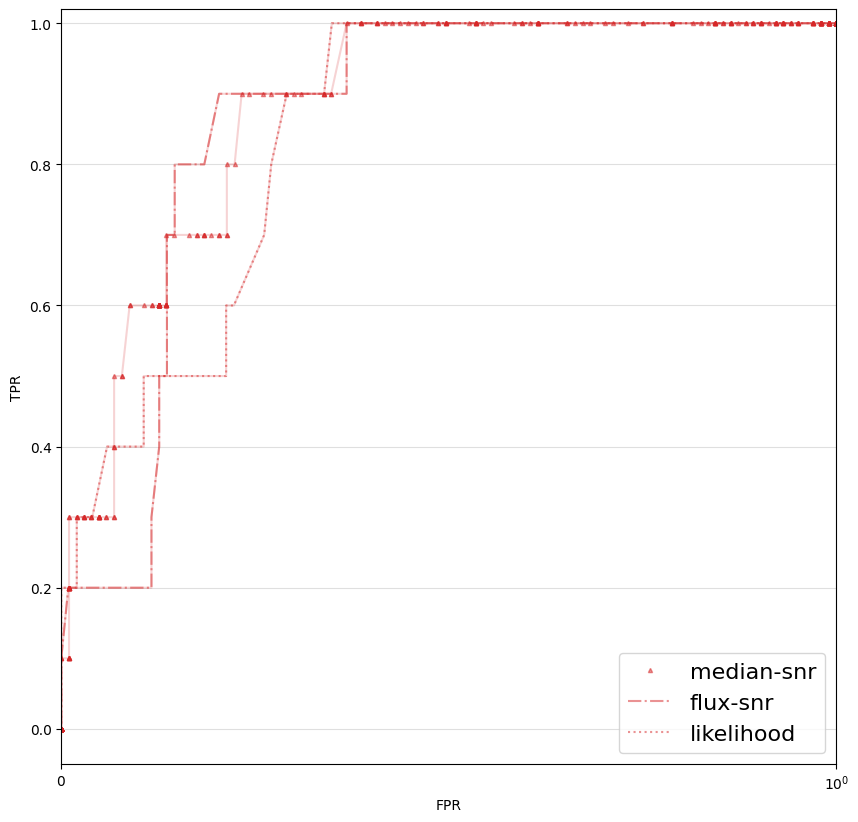

/home/hazan/Documents/papers/likelihoodmap/codes/likelihood_source.py:170: RuntimeWarning: invalid value encountered in true_divide
  residual_cube, P = (residual_cube/std)[mask], (P/std)[mask]
/home/hazan/Documents/papers/likelihoodmap/codes/likelihood_source.py:170: RuntimeWarning: invalid value encountered in true_divide
  residual_cube, P = (residual_cube/std)[mask], (P/std)[mask]
/home/hazan/Documents/papers/likelihoodmap/codes/likelihood_source.py:170: RuntimeWarning: invalid value encountered in true_divide
  residual_cube, P = (residual_cube/std)[mask], (P/std)[mask]
/home/hazan/Documents/papers/likelihoodmap/codes/likelihood_source.py:170: RuntimeWarning: invalid value encountered in true_divide
  residual_cube, P = (residual_cube/std)[mask], (P/std)[mask]
/home/hazan/Documents/papers/likelihoodmap/codes/likelihood_source.py:170: RuntimeWarning: invalid value encountered in true_divide
  residual_cube, P = (residual_cube/std)[mask], (P/std)[mask]
/home/hazan/Documents/papers/l

In [36]:
obj_roc.plot_roc_curves(figsize=(10,10), legend_size=16, hide_overlap_label=True, show_data_labels=False)